In [3]:
from time import time
import unittest
import numpy as np
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

from keras.datasets import mnist
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *
from util import importNotebook
from module.autoencoder import VAE, ConvVAE

importing Jupyter notebook from ../module/autoencoder.ipynb


In [7]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
numClass = 10
sizeDigit = xTrain.shape[1:]

dimInput = np.prod(xTrain.shape[1:])
xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


# Default parameters

In [8]:
modelPath = '../model/temp/'
vae = VAE(dimInput)
history, timeTrain = vae.fit(xTrain, xTest,
                             tempPathBest=modelPath)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.2488 - val_loss: 0.2224

Epoch 00001: val_loss improved from inf to 0.22241, saving model to ../model/temp/AutoEncoder.01-0.25-0.22.hdf5
Epoch 2/50
60000/60000 [==============================] - 7s 124us/step - loss: 0.2192 - val_loss: 0.2170

Epoch 00002: val_loss improved from 0.22241 to 0.21699, saving model to ../model/temp/AutoEncoder.02-0.22-0.22.hdf5
Epoch 3/50
60000/60000 [==============================] - 7s 123us/step - loss: 0.2152 - val_loss: 0.2140

Epoch 00003: val_loss improved from 0.21699 to 0.21404, saving model to ../model/temp/AutoEncoder.03-0.22-0.21.hdf5
Epoch 4/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.2129 - val_loss: 0.2123

Epoch 00004: val_loss improved from 0.21404 to 0.21232, saving model to ../model/temp/AutoEncoder.04-0.21-0.21.hdf5
Epoch 5/50
60000/60000 [==============================] - 8s 1

60000/60000 [==============================] - 8s 127us/step - loss: 0.1979 - val_loss: 0.1994

Epoch 00040: val_loss did not improve from 0.19929
Epoch 41/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.1979 - val_loss: 0.1992

Epoch 00041: val_loss improved from 0.19929 to 0.19922, saving model to ../model/temp/AutoEncoder.41-0.20-0.20.hdf5
Epoch 42/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.1977 - val_loss: 0.1993

Epoch 00042: val_loss did not improve from 0.19922
Epoch 43/50
60000/60000 [==============================] - 8s 127us/step - loss: 0.1977 - val_loss: 0.1992

Epoch 00043: val_loss improved from 0.19922 to 0.19919, saving model to ../model/temp/AutoEncoder.43-0.20-0.20.hdf5
Epoch 44/50
60000/60000 [==============================] - 8s 129us/step - loss: 0.1975 - val_loss: 0.1990

Epoch 00044: val_loss improved from 0.19919 to 0.19898, saving model to ../model/temp/AutoEncoder.44-0.20-0.20.hdf5
Epoch 45/50
60000/6000

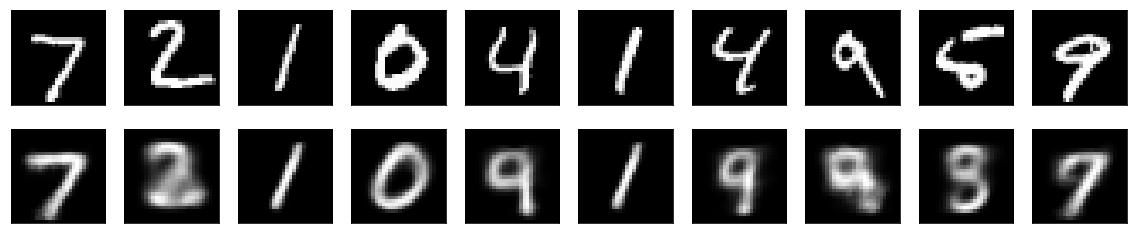

0.20697078


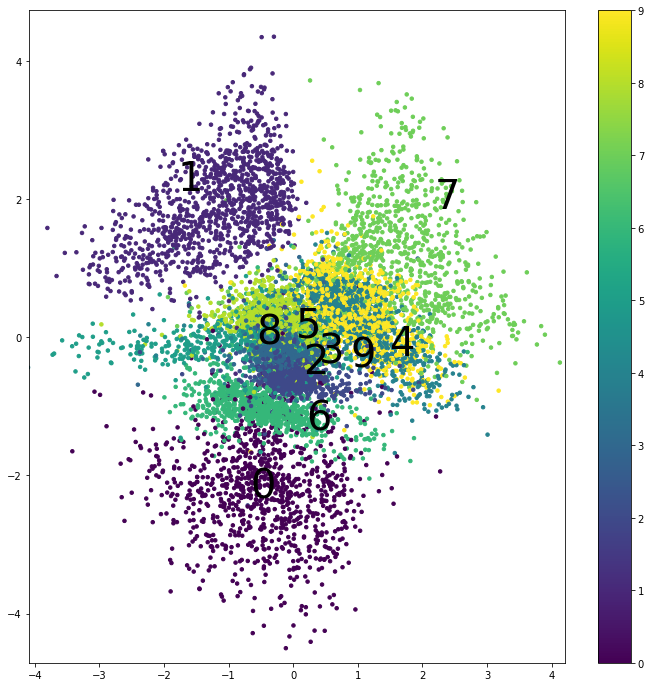

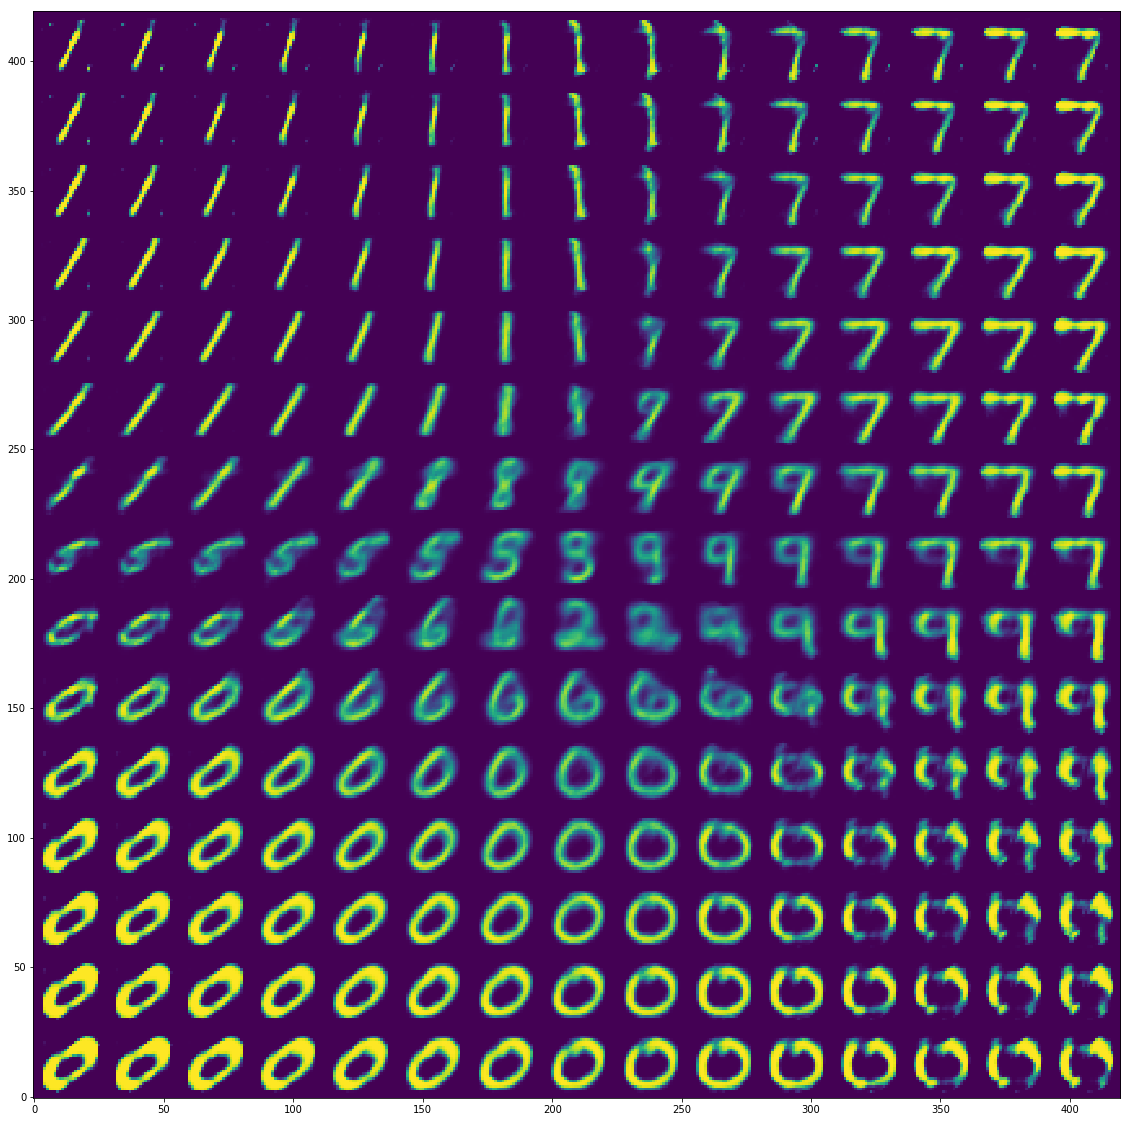

In [9]:
encoderVAE = vae.encoder
decoderVAE = vae.decoder

# Get encoded and decoded values
encodeTest = encoderVAE.predict(xTest)
decodeTest = decoderVAE.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

# Plot the comparison of original and reconstructed pictures, and calculate the errors
plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
err = compReconst(xTest, decodeTest, method='rmse')
print(err)

# Plot the scatter of the encoding space
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)    

# Plot the decoding results from the encoding scatter
plotScatterDecode(decoderVAE, sizeDigit, xlim, ylim)

In [11]:
numEpochs = 100
sizeBatch = 32
sizeKernel = 3
layerDense = [64, 16, 4]
layerConv=[8, 32]
ratRecon = 1
nameOptim = 'adam'
modelPath = '../model/temp/'
patience = 3

(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
numClass = 10
sizeDigit = xTrain.shape[1:]

dimInput = [*xTrain.shape[1:], 1]
xTrain = xTrain.reshape((numTrain, *dimInput))
xTest = xTest.reshape((numTest, *dimInput))
print(xTrain.shape)
print(xTest.shape)

convVAE = ConvVAE(dimInput, layerDense=layerDense, layerConv=layerConv, ratRecon=ratRecon)
history, timeTrain = convVAE.fit(xTrain, xTest, 
                                 numEpochs=numEpochs,
                                 sizeBatch=sizeBatch,
                                 tempPathBest=modelPath)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 18s 293us/step - loss: 0.1953 - val_loss: 0.1598

Epoch 00001: val_loss improved from inf to 0.15979, saving model to ../model/temp/Conv_AutoEncoder.01-0.20-0.16.hdf5
Epoch 2/100
60000/60000 [==============================] - 16s 267us/step - loss: 0.1562 - val_loss: 0.1523

Epoch 00002: val_loss improved from 0.15979 to 0.15235, saving model to ../model/temp/Conv_AutoEncoder.02-0.16-0.15.hdf5
Epoch 3/100
60000/60000 [==============================] - 16s 266us/step - loss: 0.1510 - val_loss: 0.1491

Epoch 00003: val_loss improved from 0.15235 to 0.14913, saving model to ../model/temp/Conv_AutoEncoder.03-0.15-0.15.hdf5
Epoch 4/100
60000/60000 [==============================] - 16s 267us/step - loss: 0.1479 - val_loss: 0.1469

Epoch 00004: val_loss improved from 0.14913 to 0.14694, saving model to ../model/temp/Conv_AutoEncoder.04-0.15-0.15.h

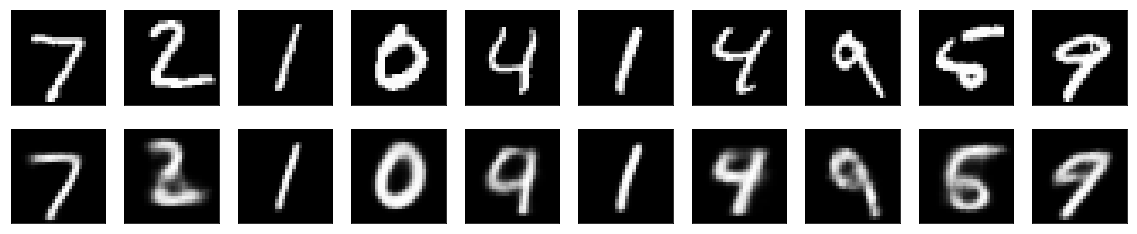

0.16177835


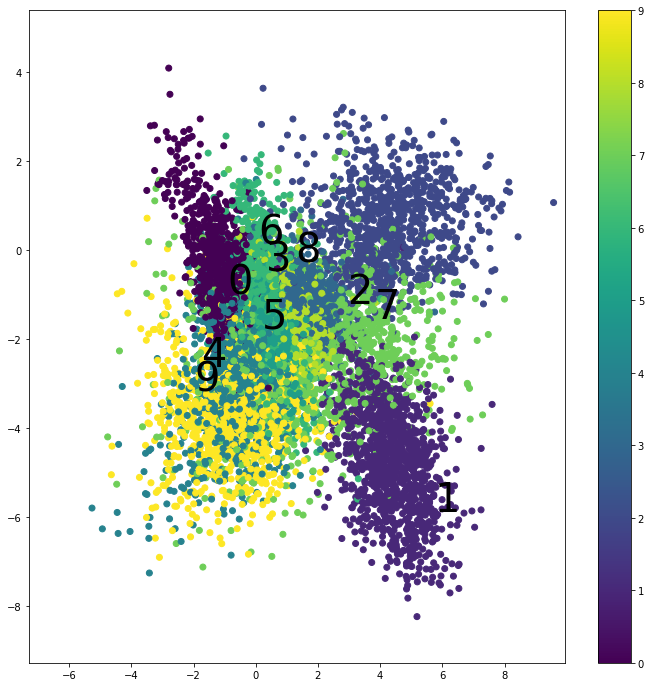

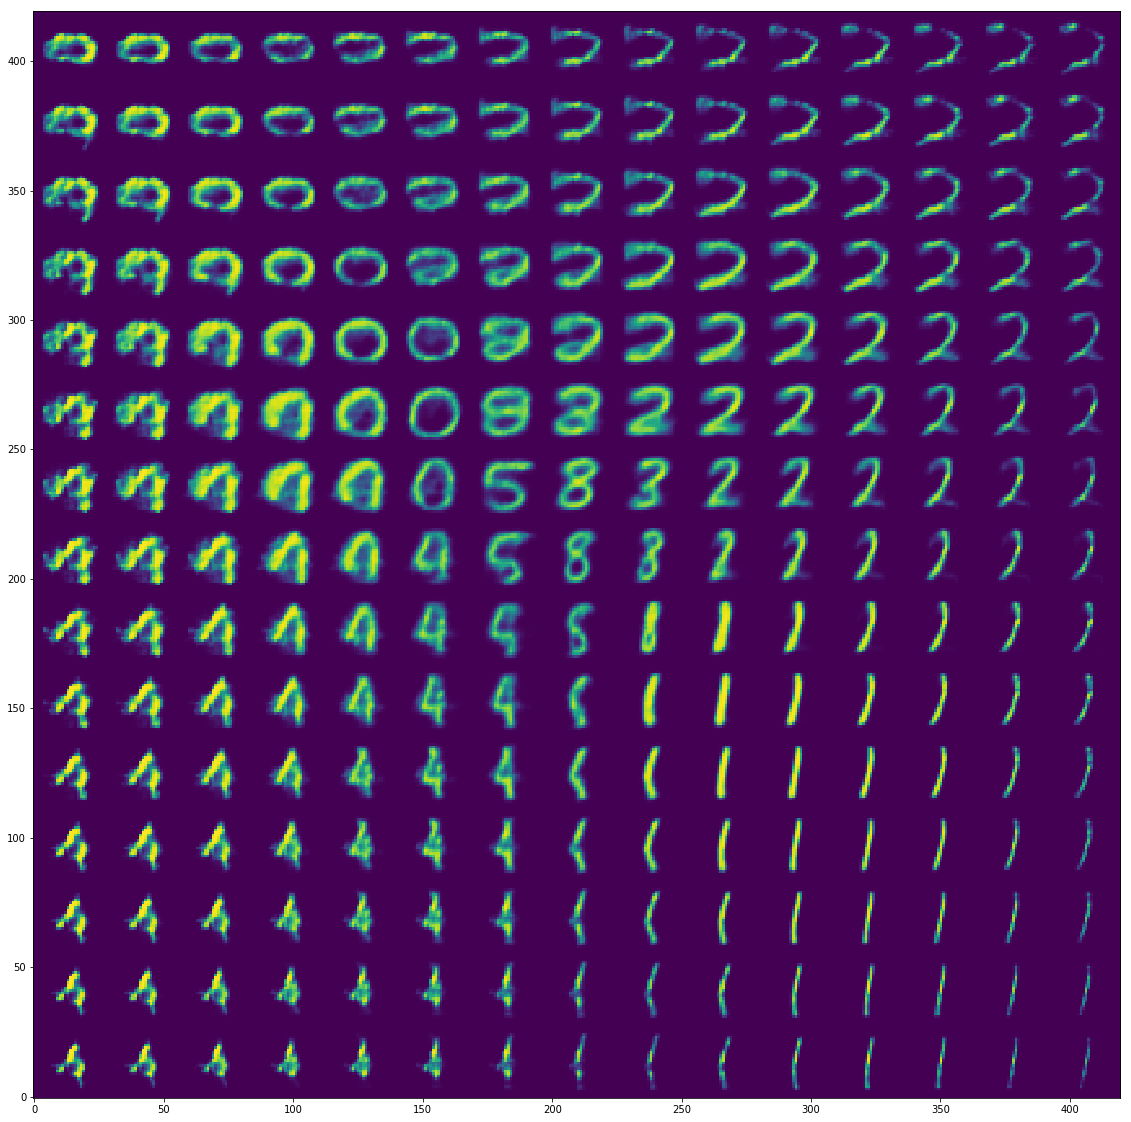

In [13]:
encoder = convVAE.encoder
decoder = convVAE.decoder

# Get encoded and decoded values
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

# Plot the comparison of original and reconstructed pictures, and calculate the errors
plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
err = compReconst(xTest, decodeTest, method='rmse')
print(err)

# Plot the scatter of the encoding space
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)    

# Plot the decoding results from the encoding scatter
plotScatterDecode(decoder, sizeDigit, xlim, ylim)